In [15]:
import torch
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
from fastdtw import fastdtw
from tslearn.clustering import TimeSeriesKMeans, KShape
from datetime import datetime
import sys
sys.path.append("../")
from config.cfg_general import CFG_GENERAL
from utils.serialization import load_pkl

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
ds_args = {
    "PEMS03":358,
    "PEMS07":883,
    "PEMS04":307,
    "PEMS08":170,
    "PEMS-BAY":325,
    "METR-LA":207
}

def gen_ds(dataset_name):
    if dataset_name in ["PEMS04","PEMS08","PEMS03","PEMS07"]:
        df = np.load(f"../datasets/raw_data/{dataset_name}/{dataset_name}.npz")['data']
        df = df[...,[0]]
        adj_mx = load_pkl(f"../datasets/raw_data/{dataset_name}/adj_{dataset_name}.pkl")
    else:
        df = pd.read_hdf("../datasets/raw_data/PEMS-BAY/PEMS-BAY.h5")
        df = np.expand_dims(df.values, axis=-1)
        adj_mx = load_pkl(f"../datasets/raw_data/{dataset_name}/adj_{dataset_name}.pkl")[2]

    num_samples = df.shape[0] - (CFG_GENERAL.DATASET.HISTORY_SEQ_LEN + CFG_GENERAL.DATASET.FUTURE_SEQ_LEN) + 1
    train_num = round(num_samples * CFG_GENERAL.DATASET.TRAIN_RATIO)
    data_train = df[:train_num+CFG_GENERAL.DATASET.HISTORY_SEQ_LEN-1]
    mean, std = data_train[..., 0].mean(), data_train[..., 0].std()
    data_norm = (df - mean)/std

    x_list = []
    for t in range(CFG_GENERAL.DATASET.HISTORY_SEQ_LEN, num_samples + CFG_GENERAL.DATASET.HISTORY_SEQ_LEN):
        x_list.append(data_norm[t-CFG_GENERAL.DATASET.HISTORY_SEQ_LEN:t])

    x_train = np.stack(x_list,axis=0)[:train_num]
    return adj_mx, x_train, df

def gen_sh_mx(dataset_name, num_nodes, adj_mx):
    sd_mx = None
    type_short_path = 'hop'
    sh_path = '{}_sh_mx.npy'.format(dataset_name)
    if not os.path.exists(sh_path):
        sh_mx = adj_mx.copy()
        if type_short_path == 'hop':
            sh_mx[sh_mx > 0] = 1
            sh_mx[sh_mx == 0] = 511
            for i in range(num_nodes):
                sh_mx[i, i] = 0
            for k in range(num_nodes):
                for i in range(num_nodes):
                    for j in range(num_nodes):
                        sh_mx[i, j] = min(sh_mx[i, j], sh_mx[i, k] + sh_mx[k, j], 511)
            np.save(sh_path, sh_mx)

    sh_mx = np.load(sh_path)
    return sh_mx


def gen_dtw(dataset_name, num_nodes, df):
    points_per_hour = 12
    cache_path = f'{dataset_name}_dtw.npy'
    if not os.path.exists(cache_path):
        data_mean = np.mean(
            [df[24 * points_per_hour * i: 24 * points_per_hour * (i + 1)]
                for i in range(df.shape[0] // (24 * points_per_hour))], axis=0)  # 
        dtw_distance = np.zeros((num_nodes, num_nodes))                          # 一天内的平均数据，
        for i in tqdm(range(num_nodes)):
            for j in range(i, num_nodes):
                dtw_distance[i][j], _ = fastdtw(data_mean[:, i, :], data_mean[:, j, :], radius=6)
        for i in range(num_nodes):
            for j in range(i):
                dtw_distance[i][j] = dtw_distance[j][i]
        np.save(cache_path, dtw_distance)
    dtw_matrix = np.load(cache_path)
    return dtw_matrix

def gen_patterns(dataset_name, x_train):
    points_per_day = 288
    output_dim = 1
    cluster_method = 'kshape'
    dataset = dataset_name
    cand_key_days = 21
    s_attn_size = 3
    n_cluster = 16
    cluster_max_iter = 5

    pattern_key_file = os.path.join(
        './', 'pattern_keys_{}_{}_{}_{}_{}_{}'.format(
            cluster_method, dataset, cand_key_days, s_attn_size, n_cluster, cluster_max_iter))

    if not os.path.exists(pattern_key_file + '.npy'):
        cand_key_time_steps = cand_key_days * points_per_day
        pattern_cand_keys = x_train[:cand_key_time_steps, :s_attn_size, :, :output_dim].swapaxes(1, 2).reshape(-1, s_attn_size, output_dim)
        if cluster_method == "kshape":
            km = KShape(n_clusters=n_cluster, max_iter=cluster_max_iter).fit(pattern_cand_keys)
        else:
            km = TimeSeriesKMeans(n_clusters=n_cluster, metric="softdtw", max_iter=cluster_max_iter).fit(pattern_cand_keys)
        pattern_keys = km.cluster_centers_
        np.save(pattern_key_file, pattern_keys)
    else:
        pattern_keys = np.load(pattern_key_file + ".npy")

    return pattern_keys

In [16]:
ds_name = "PEMS08"
num_nodes = ds_args[ds_name]
adj_mx, x_train, df = gen_ds(ds_name)
adj_mx.shape, x_train.shape, df.shape

((170, 170), (12483, 12, 170, 1), (17856, 170, 1))

sh_mx用来生成地理MASK矩阵

In [17]:
gen_sh_mx(ds_name, num_nodes, adj_mx)

array([[0., 7., 6., ..., 7., 8., 8.],
       [7., 0., 1., ..., 6., 7., 7.],
       [6., 1., 0., ..., 5., 6., 6.],
       ...,
       [7., 6., 5., ..., 0., 1., 5.],
       [8., 7., 6., ..., 1., 0., 5.],
       [8., 7., 6., ..., 5., 5., 0.]], dtype=float32)

DTW矩阵:用于生成语义mask矩阵
- 对所有数据按天进行切片和取平均 （288， 170，1）
- 对一天内的平均数据，两两计算dtw距离，得到(170,170)的矩阵

In [18]:
gen_dtw(ds_name, num_nodes, df)

array([[    0.        ,  3300.27419355,  7593.74193548, ...,
        20335.08064516,  4038.12903226, 87631.74193548],
       [ 3300.27419355,     0.        , 14321.61290323, ...,
        31621.61290323, 11455.69354839, 95935.24193548],
       [ 7593.74193548, 14321.61290323,     0.        , ...,
         8382.66129032,  4679.53225806, 67384.72580645],
       ...,
       [20335.08064516, 31621.61290323,  8382.66129032, ...,
            0.        , 12673.53225806, 47742.        ],
       [ 4038.12903226, 11455.69354839,  4679.53225806, ...,
        12673.53225806,     0.        , 79790.12903226],
       [87631.74193548, 95935.24193548, 67384.72580645, ...,
        47742.        , 79790.12903226,     0.        ]])

### k-shape时间序列聚类
[KShape：时间序列数据聚类](https://zhuanlan.zhihu.com/p/529975151?eqid=da416e19000585a7000000036477420c&utm_id=0)  
[时序聚类K-Shape](https://zhuanlan.zhihu.com/p/450068680)  
- 基于形状的聚类方法。
- K-Shape原理和K-means相似，不同在于它改进了距离计算方法，并优化了质心计算方法。一方面支持振幅缩放和平移不变性，另一方面还引入了提取频域特征方法，以提升效率，并且不用手动设置参数，便于扩展到更多领域。
- 相对于传统方法，它聚类效果更好；相对于DTW类方法，效果稍差，但速度快很多。
- 其他距离计算方法：
    - ED：欧几里得距离，最简单效率也最高，直接计算两个时间序列的距离，不考虑横向纵向缩放平移等问题。  
    - DTW：动态时间规整，考虑缩放和平移的情况，可用于比较长短不一的序列，效果好但资源占用高。
    - cDTW：DTW的限制版本，它将变化限制在一定的“带”之内，有效地提高了DTW的效率和准确率。  
    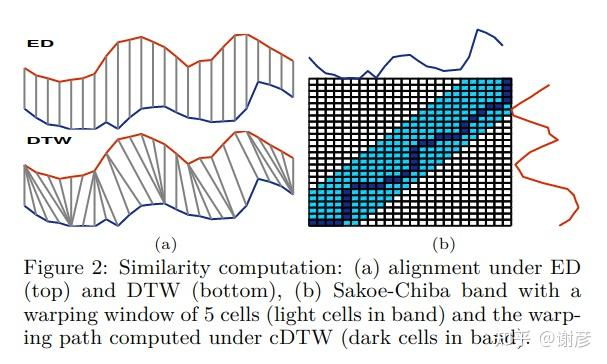
- kshape的距离计算方法：使用归一化互相关(SBD)方法计算距离

- 构建候选序列：训练集中前21天的序列的前3个时间步构成的子序列，形状为:(1028160, 3, 1) （21 * 288 * 170）
- 将候选序列聚类为16个簇，作为历史模式

In [19]:
gen_patterns(ds_name, x_train).shape

(16, 3, 1)

***
### kshape聚类可视化

In [ ]:
import numpy as np
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from tslearn.clustering import KShape
import plotly.graph_objects as go

data = np.load("../datasets/raw_data/PEMS08/PEMS08.npz")["data"][:100,:10,0].transpose(1,0)  # (10, 100)

scaler = TimeSeriesScalerMeanVariance()
data_scaled = scaler.fit_transform(data)

# 使用 K-Shape 聚类
n_clusters = 4
kshape_model = KShape(n_clusters=n_clusters, n_init=10, verbose=False, random_state=42)
labels = kshape_model.fit_predict(data_scaled)

# 输出聚类结果
print("聚类标签：", labels)
print("质心", kshape_model.cluster_centers_.shape)

fig = go.Figure()
colors = ['red','black','blue','yellow']
for i in range(data.shape[0]):
    fig.add_trace(go.Scatter(
                    y=data[i],
                    mode="lines",
                    marker=dict(color=colors[labels[i]])
                )
            )
fig.show()

聚类标签： [2 3 1 2 3 2 3 0 2 3]


In [ ]:
kshape_model.cluster_centers_.shape

(4, 100, 1)